# Multiple-objective portfolio optimization

# INTRODUCTION

Your task is to solve a multiple-objective portfolio optimization problem.
-  Use the basic Markowitz's model from 1952 (see Lecture 1)
-  Solve = construct Pareto front approximations.
-  The dataset is the same as for the portfolio game part 1 (bundle1.zip).
-  The dataset consists of the historical prices of 20 assets.
-  The bundle contains 20 files (*.txt) linked to different assets.
-  The name of the file suggests the asset's name.
-  The structure of every file is as follows:
1.  The first line contains the name of the asset.
2. The second line provides the number of data points N.
3. The following N lines are data points with the structure: time, price.
-  The historical timeline for all assets is time $\in$ [0,100].
-  Future predictions should be calculated for time = 200.

Goal: 
-  Load data, make predictions, and build the model. 
-  Illustrate your predictions (can be done in the jupyter notebook)
-  Then, implement the WSM and ECM methods (see the tutorial on quadratic programming provided below). 
-  Run your implementations for different calculation limits (e.g., the number of weight vectors for WSM). Compare the methods' efficiency in finding unique Pareto optimal solutions. Finally, illustrate generated Pareto fronts.

In [2]:
import pycaret
from pycaret.time_series import *
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import ElasticNet
from scipy.special import comb
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

In [3]:


solvers.options['show_progress'] = False
order = ["SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons", "SpaceNow", "PearPear",
         "PositiveCorrelation", "BetterTechnology", "ABCDE", "EnviroLike", "Moneymakers", "Fuel4",
         "MarsProject", "CPU-XYZ", "RoboticsX", "Lasers", "WaterForce", "SafeAndCare", "BetterTomorrow"]


In [4]:
times=np.array([x for x in range(1,101)])

### Data loading

In [5]:

def load_asset_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    asset_name = lines[0].strip()
    n_points = int(lines[1].strip())
    
    prices = []
    
    for i in range(2, 2 + n_points):
        _, p = map(float, lines[i].strip().split())
      
        prices.append(p)
    
    return asset_name, np.array(prices)
def load_all_assets(directory_path, log=True):
    asset_files = glob.glob(os.path.join(directory_path, "*.txt"))
    assets = {}
    
    for file_path in asset_files:
        asset_name, prices = load_asset_data(file_path)
        if log:
          prices=[np.log(prices[x]/prices[x-1])*100 for x in range(1,len(prices))]
      
        assets[asset_name] = prices
        
    return assets

In [27]:
data_dir = './data/bundle1'  
assets = load_all_assets(data_dir)

### Defining predictions

In [7]:
def linear_prediction( prices, target_time=200):
    model = ElasticNet()
    times_reshaped = times.reshape(-1, 1)

    model.fit(times_reshaped, prices)
    return model.predict(np.array([x for x in range(101, target_time+1)]).reshape(-1,1))

In [8]:


def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps]) 
        y.append(data[i + time_steps]) 
    return np.array(X), np.array(y)


def lstm_prediction(prices, target_time=200, time_steps=10):
    prices = np.array(prices).reshape(-1, 1)
    scaler = StandardScaler()
    prices_scaled = scaler.fit_transform(prices)
    X_train, y_train = create_sequences(prices_scaled, time_steps)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(time_steps, 1))),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dense(1)
])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
    train_predictions = model.predict(X_train, verbose=0)
    train_predictions = scaler.inverse_transform(train_predictions)
    future_prices = list(prices_scaled[-time_steps:].flatten())  
    predictions = []

    for _ in range(target_time - 100 ): 
        seq=future_prices[-time_steps:]
    
        last_sequence = np.array(seq).reshape(1, time_steps, 1)
        next_price = model.predict(last_sequence, verbose=0)[0, 0]
        predictions.append(next_price)
        future_prices.append(next_price) 
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    
    return predictions

In [96]:
def compute_returns(assets, target_time=200):
    expected_returns = {}
    for asset_name, prices in assets.items():  
  
        predicted_price = linear_prediction( prices, target_time).sum()    
        expected_returns[asset_name] = predicted_price
    return expected_returns

expected_returns = compute_returns(assets)

def compute_covariance_matrix(assets):
    returns_matrix = np.array(list(assets.values()))
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix

cov_matrix=compute_covariance_matrix(assets)


### WSM, ECM, Optimization

In [10]:
def optimize_portfolio(expected_returns, cov_matrix, asset_names, target_return=None, w1=1.0, w2=1.0):
    n_assets = len(asset_names)
    mu = np.array([expected_returns[asset] for asset in asset_names], dtype=np.float64)
    Q = matrix(2*w2*cov_matrix.T)
    c = matrix(np.zeros(n_assets))
    if w1+w2<2:
        c=matrix(-w1*mu)

    A = matrix(np.ones((1, n_assets)))
    b = matrix(1.0)
    
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    if target_return is not None:
        G = matrix(np.vstack((-mu, -np.eye(n_assets))))
        h = matrix(np.hstack((-target_return, np.zeros(n_assets))))  
    solution = solvers.qp(Q, c, G, h, A, b)
    weights = np.array(solution['x']).flatten()
    weights=weights/weights.sum()
    portfolio_return = np.dot(weights, mu)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    return weights, portfolio_return, portfolio_risk

In [11]:
def wsm_method(expected_returns, cov_matrix, asset_names, n_points=100):
    returns = []
    risks = []
    all_weights = []

    lambdas = np.linspace(0, 1, n_points)
    _,portfolio_return1,portfolio_risk1=optimize_portfolio(expected_returns, cov_matrix, asset_names,target_return=None, w1=1, w2=0)
    _,portfolio_return2,portfolio_risk2=optimize_portfolio(expected_returns, cov_matrix, asset_names,target_return=None, w1=0, w2=1)
    max_risk=max(portfolio_risk1,portfolio_risk2)
    max_return=max(portfolio_return1, portfolio_return2)
    min_risk=min(portfolio_risk1,portfolio_risk2)
    min_return=min(portfolio_return1, portfolio_return2)
    drisk,dreturn=max_risk-min_risk, max_return-min_return
    for lambd in lambdas:
        weights, portfolio_return, portfolio_risk=optimize_portfolio(expected_returns, cov_matrix, asset_names,target_return=None, w1=lambd/dreturn, w2=(1-lambd)/drisk)
        returns.append(portfolio_return)
        risks.append(portfolio_risk)
        all_weights.append(weights)
    return np.array(risks), np.array(returns), np.array(all_weights)

In [12]:
def ecm_method(expected_returns, cov_matrix, asset_names, n_points=100):
    returns = []
    risks = []
    all_weights = []
    mu = np.array([expected_returns[asset] for asset in asset_names])
    max_return_idx = np.argmax(mu)
    max_return = mu[max_return_idx]
    _, min_return, _ = optimize_portfolio(expected_returns, cov_matrix, asset_names)
    return_levels = np.linspace(min_return, max_return, n_points)
    for target_return in return_levels:
        weights, actual_return, risk = optimize_portfolio(expected_returns, cov_matrix, asset_names, target_return=target_return)
        returns.append(actual_return)
        risks.append(risk)
        all_weights.append(weights)
        
    return np.array(risks), np.array(returns), np.array(all_weights)

In [13]:
def filter_unique_solutions(risks, returns, tolerance=1e-4):
    points = np.column_stack((risks, returns))
    unique_points = []
    for point in points:
        is_unique = True
        for unique_point in unique_points:
            if np.all(np.abs(point - unique_point) < tolerance):
                is_unique = False
                break
        if is_unique:
            unique_points.append(point)
    return np.array(unique_points)

In [14]:

def das_dennis(n_assets=20, num_points=100000):
    H = 1
    while comb(n_assets + H - 1, H, exact=True) < num_points:
        H += 1
    partitions = itertools.combinations_with_replacement(range(H + 1), n_assets - 1)
    weight_vectors = []
    for partition in partitions:
        full_partition = (0,) + partition + (H,)
        weights = np.diff(full_partition) / H
        weight_vectors.append(weights)
        if len(weight_vectors) >= num_points:
            break
    return np.array(weight_vectors)

In [15]:
def caret_predict(prices):
    data=np.array(prices)
    data=pd.DataFrame(data=data, columns=['x'])
    s=setup(data, verbose=0)
    best=compare_models(verbose=0)
    predictions=predict_model(best, fh=101)
    return predictions.values

### Linear predictions

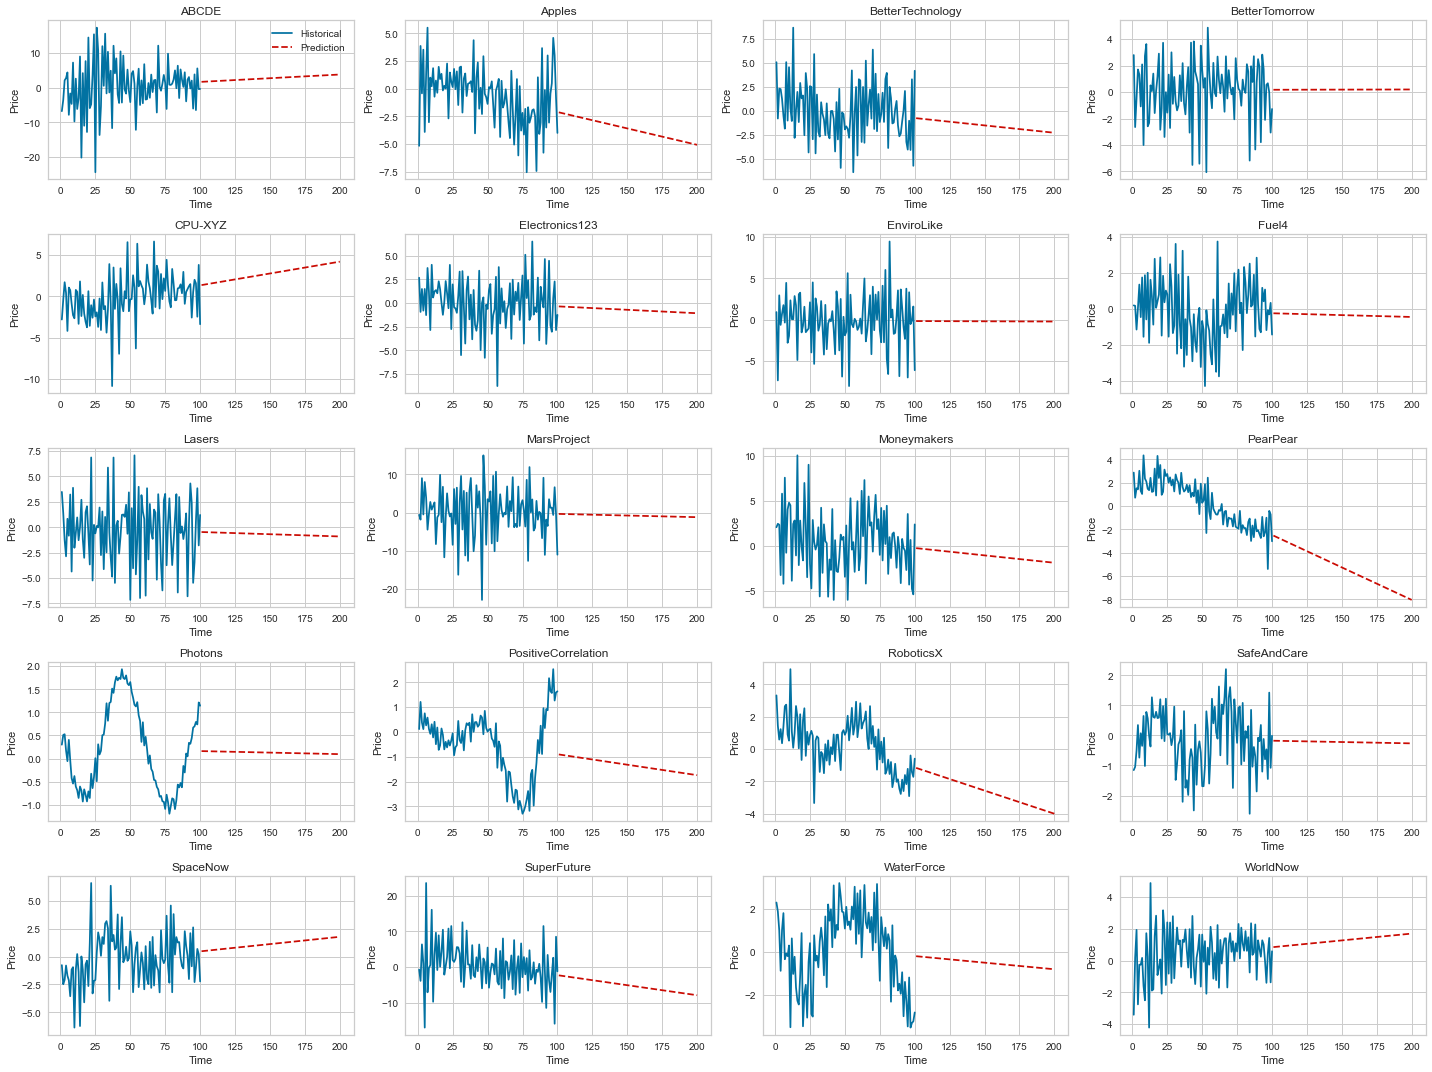

In [97]:
plt.figure(figsize=(20, 15))
for i, (asset_name, prices) in enumerate(assets.items()):
    pred_prices=linear_prediction(prices)
    pred_times = np.array([x for x in range(times[-1]+1, 201)])
   
    plt.subplot(5, 4, i+1)
    plt.plot(times, prices, 'b-', label='Historical')
    plt.plot(pred_times, pred_prices, 'r--', label='Prediction')
    plt.title(asset_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if i == 0:  
        plt.legend()

plt.tight_layout()
plt.show()


Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10          10         10          10       0.31079   
1        50         50          50         50          50       0.31079   
2       200        200         200        200         200       0.31079   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0       0.31079      277.321038      277.321079  
1       0.31079      277.321038      277.321079  
2       0.31079      277.321038      277.321079  


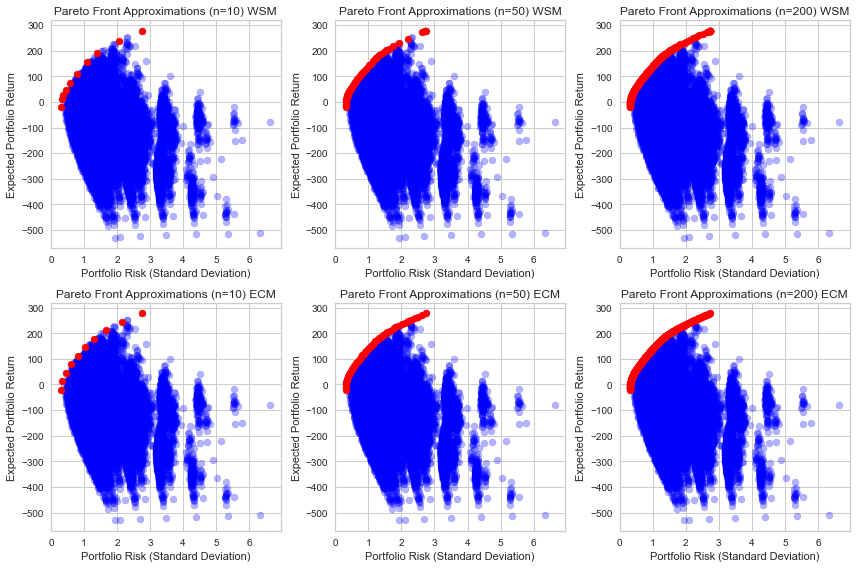

In [98]:
asset_names=list(assets.keys())
sampling=das_dennis(num_points=100_000)
mu=np.array([expected_returns[asset] for asset in asset_names])
def risk(x):
    return np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), np.dot(x, mu)
sampling_risks,sampling_returns=zip(*[risk(x) for x in sampling])
n_points_list = [10,50,200]
results = {}

for n_points in n_points_list:
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, n_points in enumerate(n_points_list):
    ax = axes[i]
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['wsm']['risks'], result['wsm']['returns'], 
               c='red', alpha=1)

    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) WSM')
  
for i, n_points in enumerate(n_points_list):
    ax = axes[i + len(n_points_list)]  
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['ecm']['risks'], result['ecm']['returns'], 
               c='red', alpha=1)
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) ECM')

plt.tight_layout()
plt.show()

### Predictions made with pycaret

In [92]:
def compute_returns(assets, target_time=200):
    expected_returns = {}
    for asset_name, prices in assets.items():  
  
        predicted_price = (caret_predict( prices))[1:].sum()    
        expected_returns[asset_name] = predicted_price
    return expected_returns

expected_returns = compute_returns(assets)

def compute_covariance_matrix(assets):
    returns_matrix = np.array(list(assets.values()))
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix

cov_matrix=compute_covariance_matrix(assets)


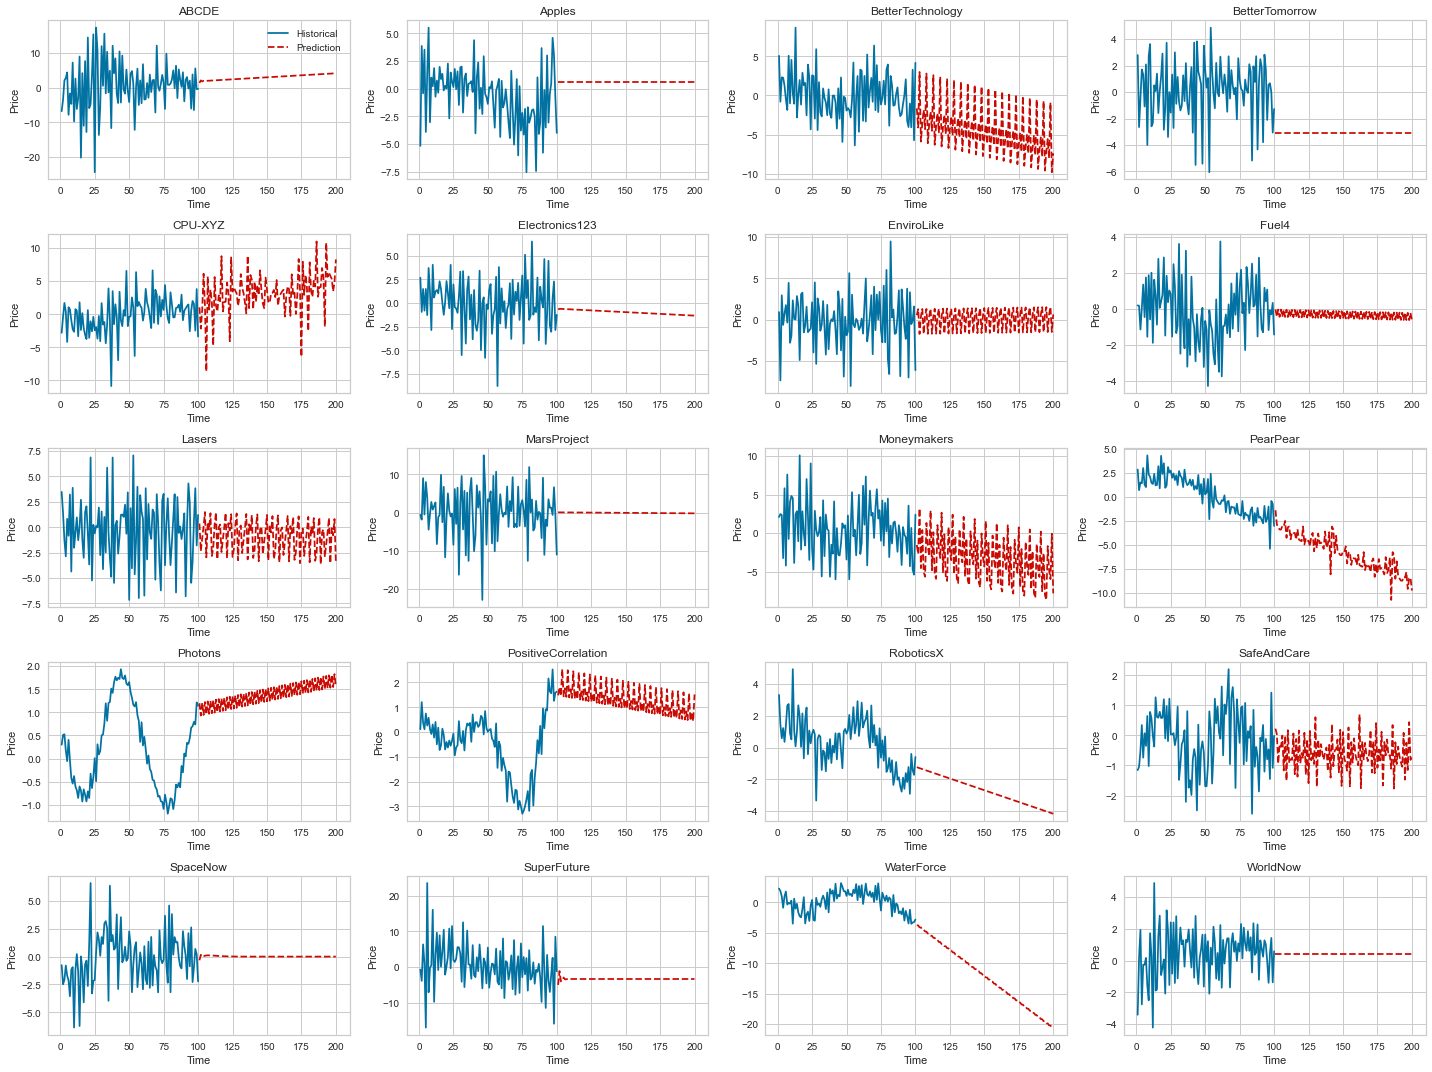

In [91]:
plt.figure(figsize=(20, 15))
for i, (asset_name, prices) in enumerate(assets.items()):
    pred_prices=caret_predict(prices)[1:]
    pred_times = np.array([x for x in range(times[-1]+1, 201)])
   
    plt.subplot(5, 4, i+1)
    plt.plot(times, prices, 'b-', label='Historical')
    plt.plot(pred_times, pred_prices, 'r--', label='Prediction')
    plt.title(asset_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if i == 0:  
        plt.legend()

plt.tight_layout()
plt.show()


Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10          10         10          10       0.31079   
1        50         50          50         50          50       0.31079   
2       200        200         197        200         200       0.31079   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0       0.31079      324.099495        324.0995  
1       0.31079      324.099495        324.0995  
2       0.31079      324.099495        324.0995  


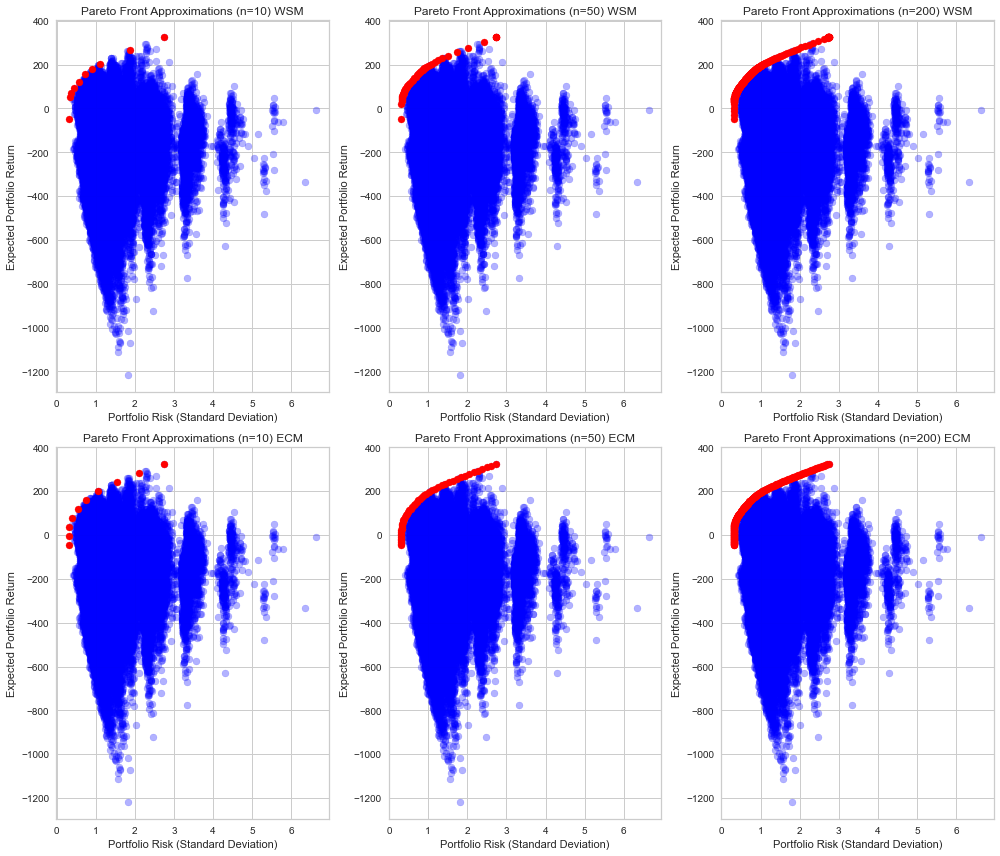

In [94]:
asset_names=list(assets.keys())
sampling=das_dennis(num_points=100_000)
mu=np.array([expected_returns[asset] for asset in asset_names])
def risk(x):
    return np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), np.dot(x, mu)
sampling_risks,sampling_returns=zip(*[risk(x) for x in sampling])
n_points_list = [10,50,200]
results = {}

for n_points in n_points_list:
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)


fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()
for i, n_points in enumerate(n_points_list):
    ax = axes[i]
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['wsm']['risks'], result['wsm']['returns'], 
               c='red', alpha=1)

    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) WSM')
  
for i, n_points in enumerate(n_points_list):
    ax = axes[i + len(n_points_list)]  
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['ecm']['risks'], result['ecm']['returns'], 
               c='red', alpha=1)
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) ECM')

plt.tight_layout()
plt.show()

### LSTM predictions

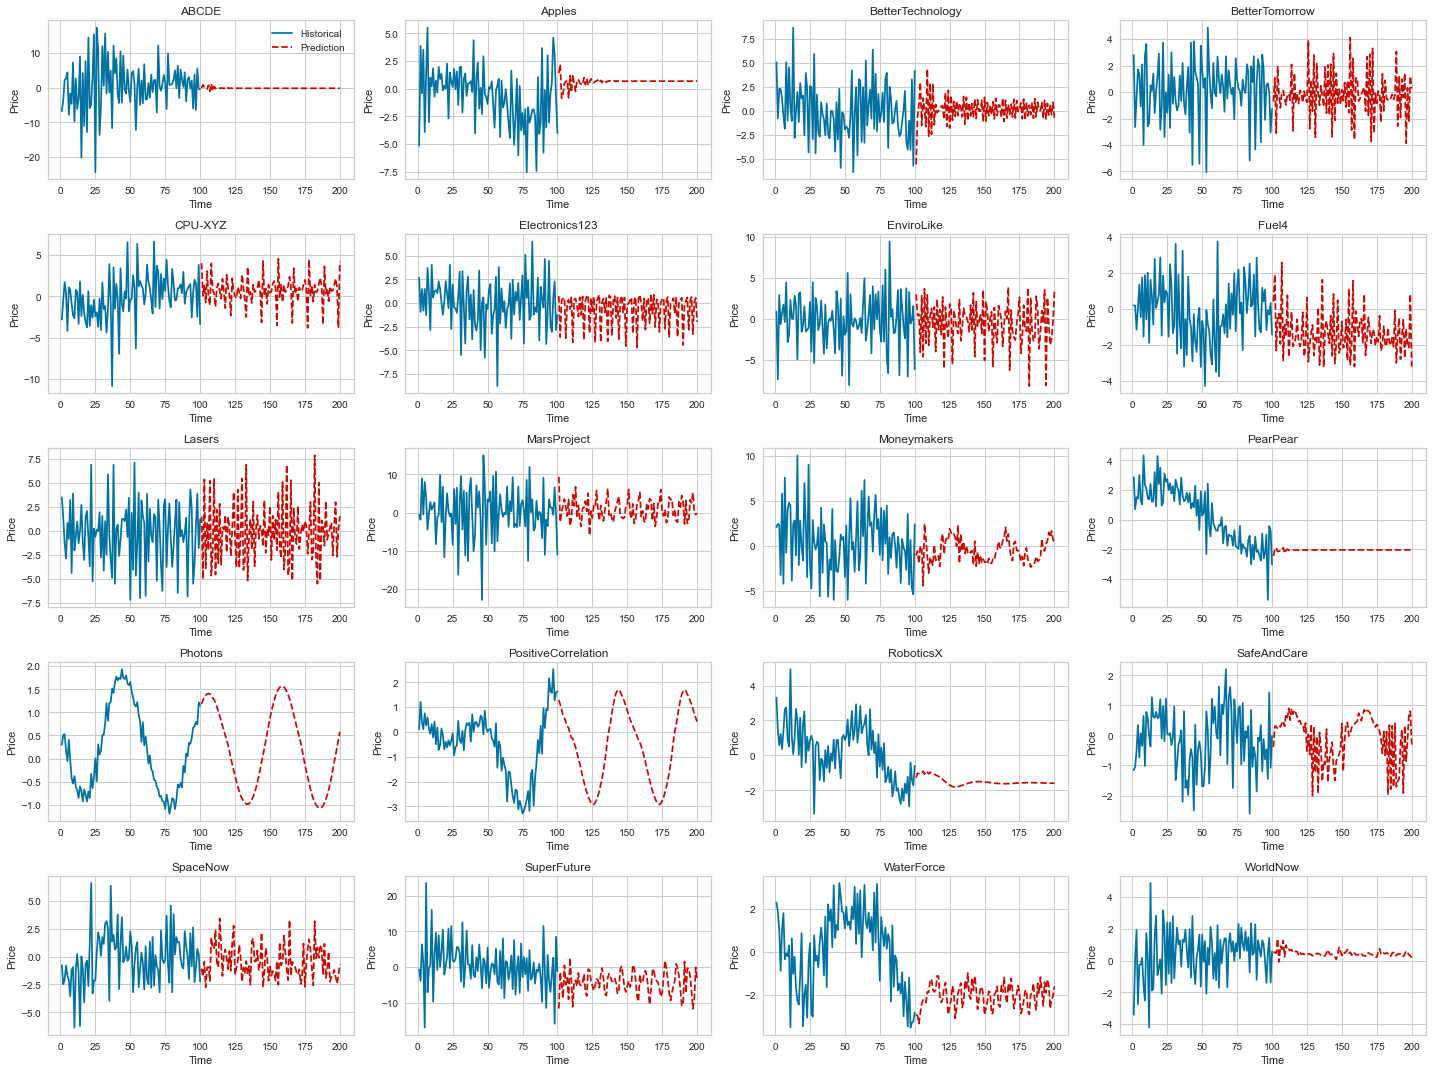

In [102]:
def compute_returns(assets, target_time=200):
    expected_returns = {}
    plt.figure(figsize=(20, 15))
    for i, (asset_name, prices) in enumerate(assets.items()):  
  
        predicted_price = lstm_prediction(prices, target_time=200)    
        expected_returns[asset_name] = predicted_price.sum()
        pred_times = np.array([x for x in range(times[-1]+1, 201)])
   
        plt.subplot(5, 4, i+1)
        plt.plot(times, prices, 'b-', label='Historical')
        plt.plot(pred_times, predicted_price, 'r--', label='Prediction')
        plt.title(asset_name)
        plt.xlabel('Time')
        plt.ylabel('Price')
        
        if i == 0:  
            plt.legend()
    plt.tight_layout()
    plt.show()
    return expected_returns

expected_returns = compute_returns(assets)

def compute_covariance_matrix(assets):
    returns_matrix = np.array(list(assets.values()))
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix

cov_matrix=compute_covariance_matrix(assets)



Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10          10         10          10       0.31079   
1        50         50          50         50          50       0.31079   
2       200        200         200        200         200       0.31079   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0       0.31079       82.897666       82.897667  
1       0.31079       82.897666       82.897667  
2       0.31079       82.897666       82.897667  


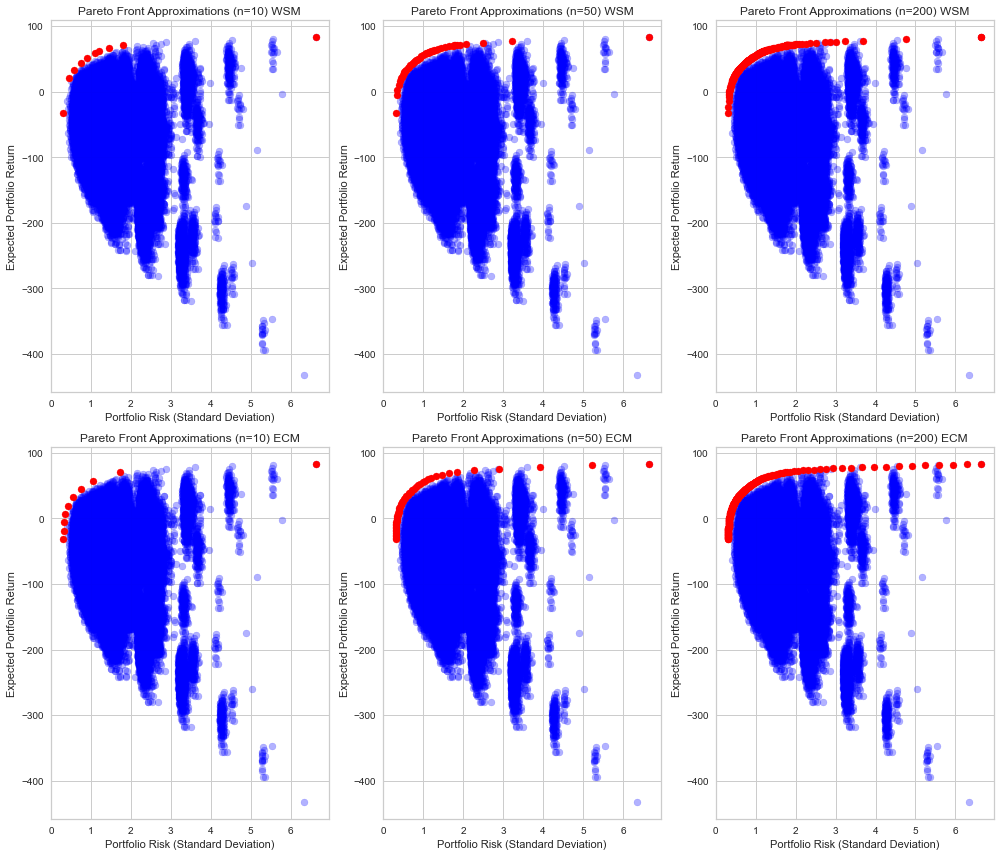

In [103]:
asset_names=list(assets.keys())
sampling=das_dennis(num_points=100_000)

mu=np.array([expected_returns[asset] for asset in asset_names])
def risk(x):
    return np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), np.dot(x, mu)
sampling_risks,sampling_returns=zip(*[risk(x) for x in sampling])
n_points_list = [10,50,200]
results = {}

for n_points in n_points_list:
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)


fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()
for i, n_points in enumerate(n_points_list):
    ax = axes[i]
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['wsm']['risks'], result['wsm']['returns'], 
               c='red', alpha=1)

    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) WSM')
  
for i, n_points in enumerate(n_points_list):
    ax = axes[i + len(n_points_list)]  
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['ecm']['risks'], result['ecm']['returns'], 
               c='red', alpha=1)
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) ECM')

plt.tight_layout()
plt.show()

### LSTM predictions on prices

In [18]:
assets = load_all_assets(data_dir, log=False)

In [ ]:
def compute_returns(assets, target_time=200):
    expected_returns = {}
    for asset_name, prices in assets.items():  
  
        predicted_price = lstm_prediction(prices, target_time=200)[-1] 
        expected_returns[asset_name] = 100*(predicted_price-prices[-1])/prices[-1]
    return expected_returns

expected_returns = compute_returns(assets)

def compute_covariance_matrix(assets):
    returns_matrix = np.array(list(assets.values()))
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix

cov_matrix=compute_covariance_matrix(assets)


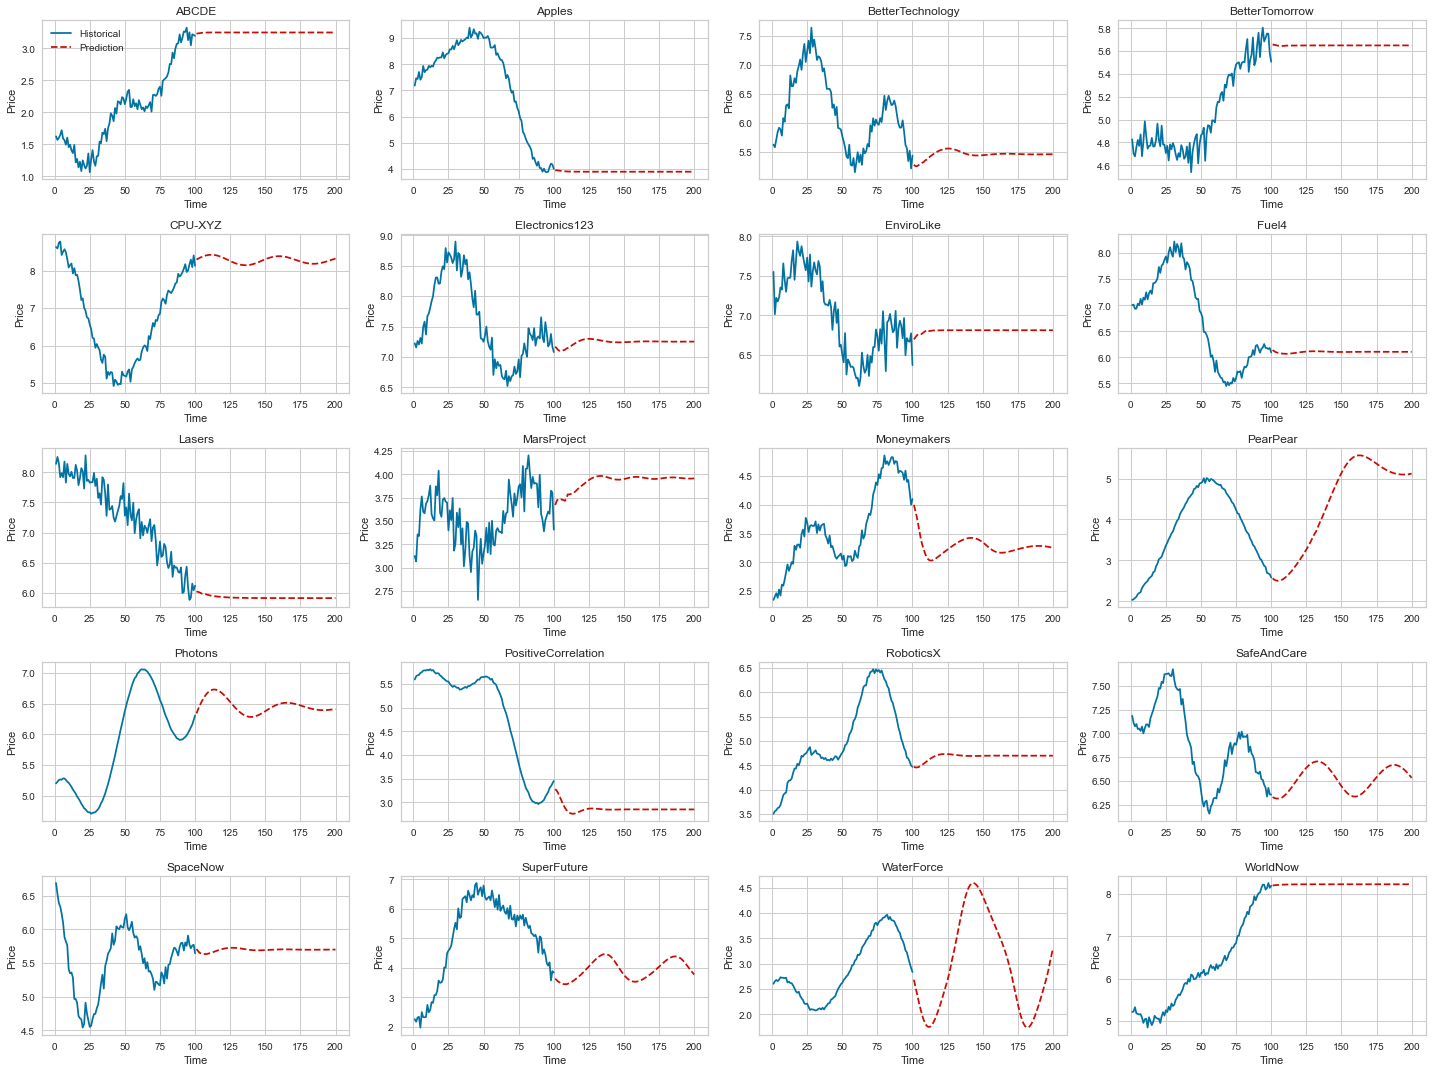

In [20]:
plt.figure(figsize=(20, 15))
for i, (asset_name, prices) in enumerate(assets.items()):
    pred_prices=lstm_prediction(prices, target_time=200)
    pred_times = np.array([x for x in range(times[-1]+1, 201)])
   
    plt.subplot(5, 4, i+1)
    plt.plot(times, prices[1:], 'b-', label='Historical')
    plt.plot(pred_times, pred_prices, 'r--', label='Prediction')
    plt.title(asset_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if i == 0:  
        plt.legend()

plt.tight_layout()
plt.show()


Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10           9         10          10      0.013281   
1        50         50          41         50          50      0.013281   
2       200        200         161        200         200      0.013281   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0      0.013281       50.562048       50.562054  
1      0.013281       50.562050       50.562054  
2      0.013281       50.562052       50.562054  


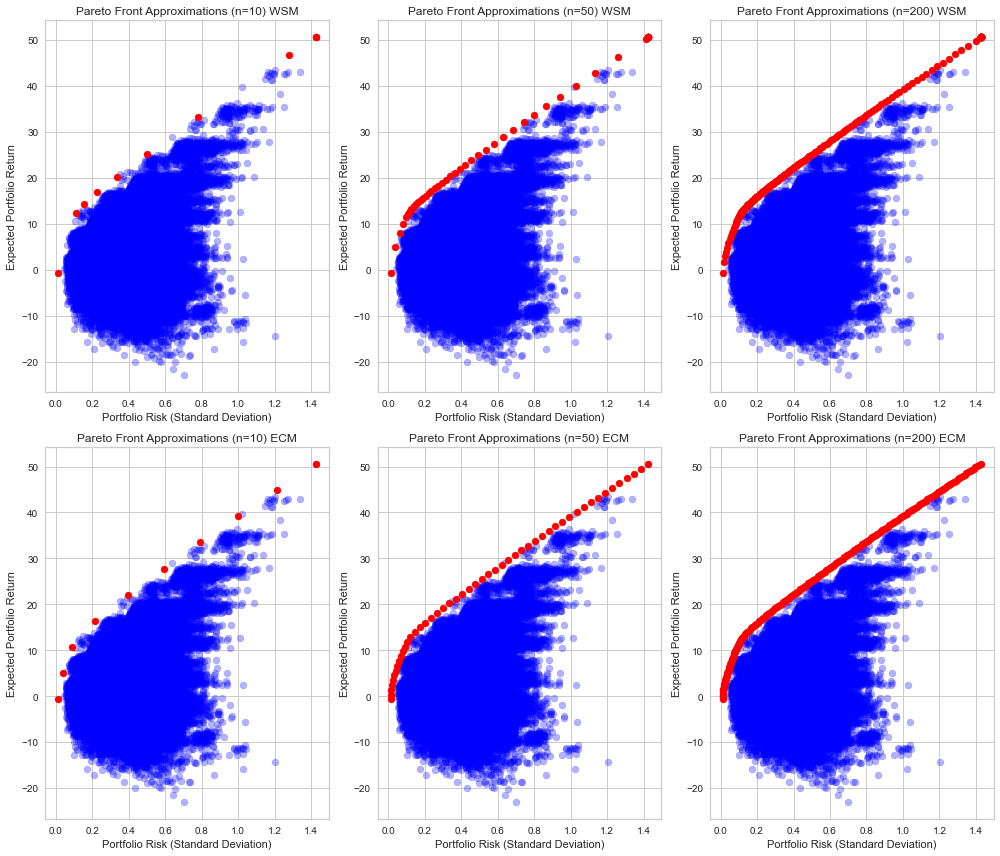

In [29]:
asset_names=list(assets.keys())
sampling=das_dennis(num_points=100_000)
mu=np.array([expected_returns[asset] for asset in asset_names])
def risk(x):
    return np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), np.dot(x, mu)
sampling_risks,sampling_returns=zip(*[risk(x) for x in sampling])
n_points_list = [10,50,200]
results = {}

for n_points in n_points_list:
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)


fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()
for i, n_points in enumerate(n_points_list):
    ax = axes[i]
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['wsm']['risks'], result['wsm']['returns'], 
               c='red', alpha=1)

    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) WSM')
  
for i, n_points in enumerate(n_points_list):
    ax = axes[i + len(n_points_list)]  
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['ecm']['risks'], result['ecm']['returns'], 
               c='red', alpha=1)
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) ECM')

plt.tight_layout()
plt.show()

### Caret predictions on prices

In [16]:
assets = load_all_assets(data_dir, log=False)

In [17]:
def compute_returns(assets, target_time=200):
    expected_returns = {}
    for asset_name, prices in assets.items():  
  
        predicted_price = (caret_predict( prices))[-1]  
        expected_returns[asset_name] = 100*(predicted_price-prices[-1])/prices[-1]
    return expected_returns

expected_returns = compute_returns(assets)

def compute_covariance_matrix(assets):
    returns_matrix = np.array(list(assets.values()))
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix

cov_matrix=compute_covariance_matrix(assets)


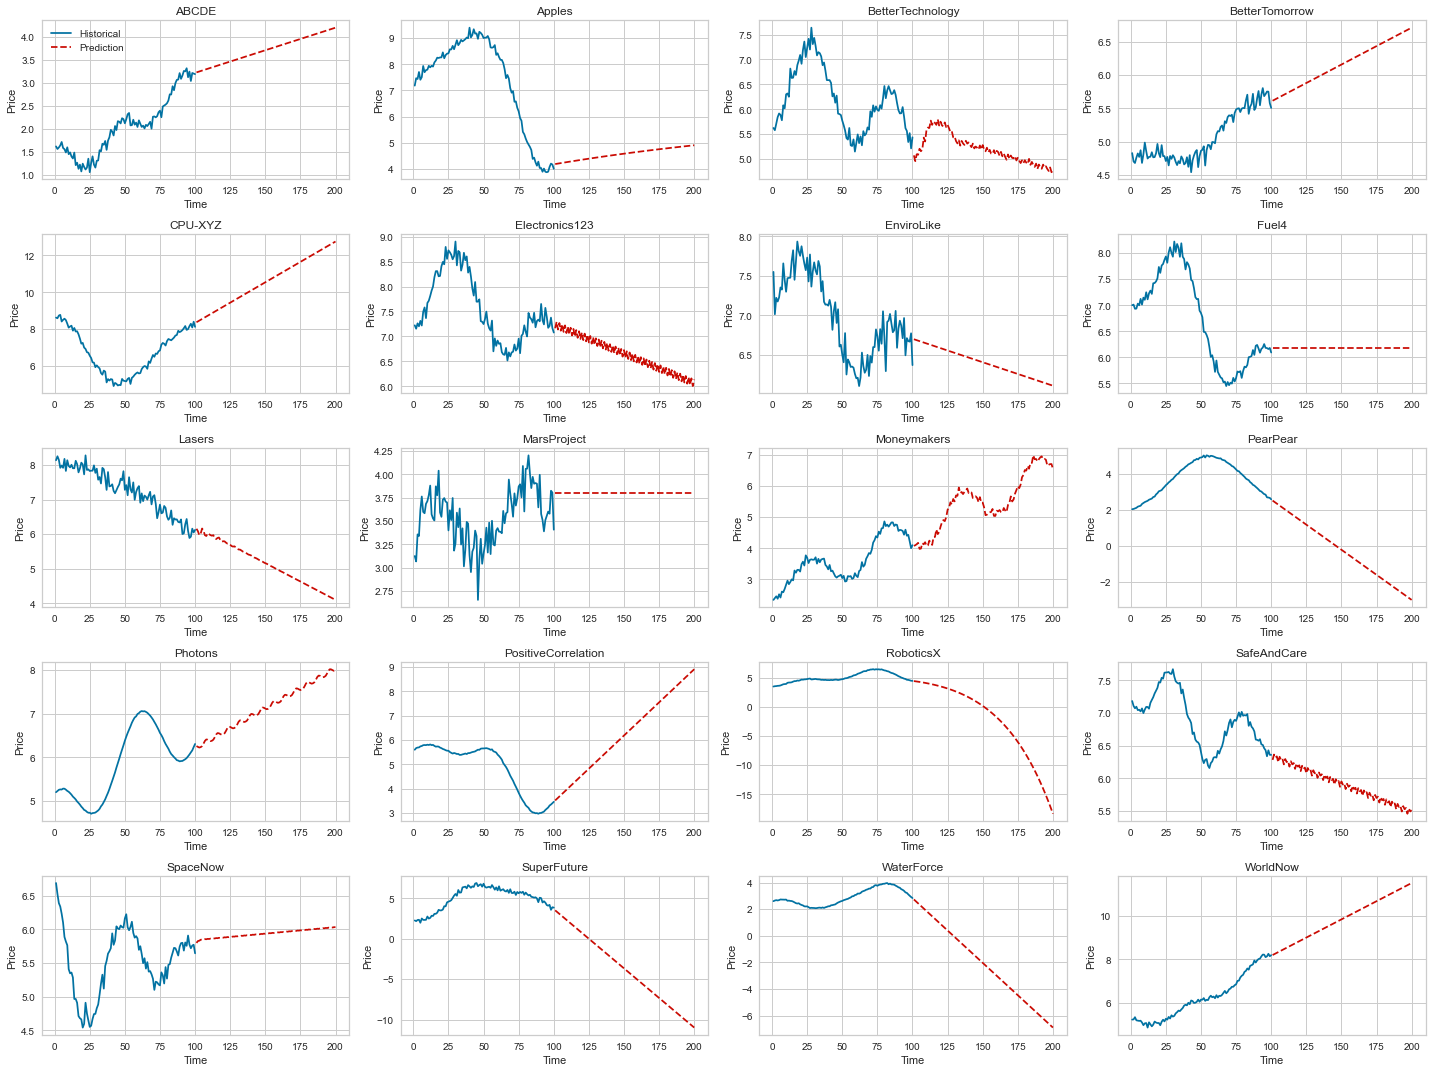

In [19]:
plt.figure(figsize=(20, 15))
for i, (asset_name, prices) in enumerate(assets.items()):
    pred_prices=caret_predict(prices)[1:]
    pred_times = np.array([x for x in range(times[-1]+1, 201)])
   
    plt.subplot(5, 4, i+1)
    plt.plot(times, prices[1:], 'b-', label='Historical')
    plt.plot(pred_times, pred_prices, 'r--', label='Prediction')
    plt.title(asset_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if i == 0:  
        plt.legend()

plt.tight_layout()
plt.show()


Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10           9         10          10      0.013281   
1        50         50          44         50          50      0.013281   
2       200        200         169        200         200      0.013281   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0      0.013281      158.157904      158.157907  
1      0.013281      158.157905      158.157907  
2      0.013281      158.157905      158.157907  


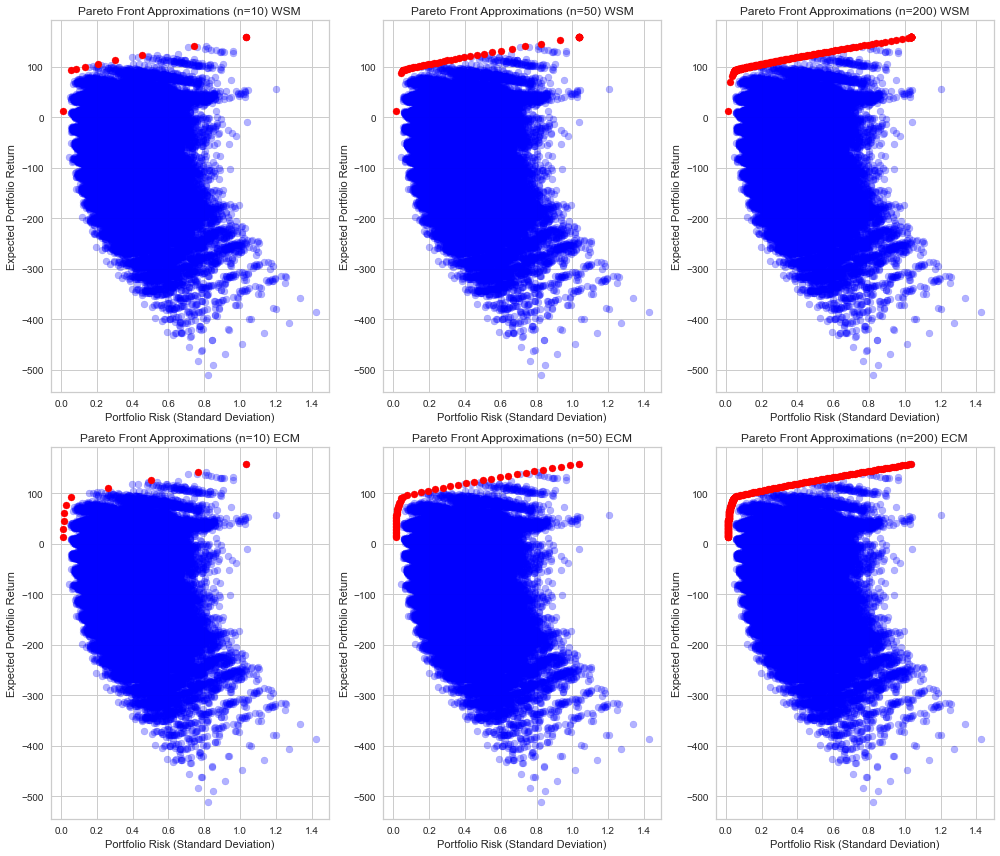

In [26]:
asset_names=list(assets.keys())
sampling=das_dennis(num_points=100_000)
mu=np.array([expected_returns[asset] for asset in asset_names])
def risk(x):
    return np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), np.dot(x, mu)
sampling_risks,sampling_returns=zip(*[risk(x) for x in sampling])
n_points_list = [10,50,200]
results = {}

for n_points in n_points_list:
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points)
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)


fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()
for i, n_points in enumerate(n_points_list):
    ax = axes[i]
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['wsm']['risks'], result['wsm']['returns'], 
               c='red', alpha=1)

    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) WSM')
  
for i, n_points in enumerate(n_points_list):
    ax = axes[i + len(n_points_list)]  
    result = results[n_points]
    ax.scatter(sampling_risks, sampling_returns, c='blue', alpha=0.3)
    ax.scatter(result['ecm']['risks'], result['ecm']['returns'], 
               c='red', alpha=1)
    ax.set_xlabel('Portfolio Risk (Standard Deviation)')
    ax.set_ylabel('Expected Portfolio Return')
    ax.set_title(f'Pareto Front Approximations (n={n_points}) ECM')

plt.tight_layout()
plt.show()

### SARIMAX

In [22]:
assets = load_all_assets(data_dir)

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


In [25]:
for i, (asset_name, prices) in enumerate(assets.items()):
    check_stationarity(prices)

Stationary
Non-Stationary
Non-Stationary
Stationary
Non-Stationary
Non-Stationary
Stationary
Non-Stationary
Stationary
Stationary
Non-Stationary
Non-Stationary
Stationary
Stationary
Stationary
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary


The data doesn't pass stationarity tests - can't be used here 

### Portfolio Game

In [106]:
def get_portfolio(results):
    returns=results[200]['ecm']['returns']
    weights=results[200]['ecm']['weights']
    risks=results[200]['ecm']['risks']
    for i  in range(len(risks)):
        if returns[i] <0:
            continue
        chosen_weights=np.array(weights[i])
        print(chosen_weights)
        sw=chosen_weights[np.argsort(np.argsort(order))]
        print(sw)
        print(returns[i])
        creturn=np.exp(returns[i]/100)*100
        d=pd.DataFrame(data=np.array([np.array(sw), order]).T, columns=['w', 'n'])
        d['w']=pd.to_numeric(d['w'])
        d=d.sort_values(by=['w'], ascending=False)
        with open('151928_151934.txt', 'w') as f:
            l=[creturn, risks[i]]
            l.extend(sw)
       
            l=[f'{x:.10f}' for x in l]
            line=' '.join(l)
            f.writelines(line)
            return d
        

In [107]:
get_portfolio(results)

[5.35624547e-04 2.16130091e-02 3.52268641e-02 1.21200562e-02
 4.36264016e-02 4.37083566e-02 9.52659170e-03 6.89550465e-02
 1.98596860e-09 6.79408088e-03 1.27460409e-02 4.60322514e-11
 4.06370859e-01 1.39358379e-08 1.14449825e-10 2.66909886e-01
 1.66226249e-02 2.07624152e-11 3.73245348e-11 5.52445414e-02]
[2.07624152e-11 2.16130091e-02 5.52445414e-02 4.37083566e-02
 4.06370859e-01 1.66226249e-02 4.60322514e-11 1.39358379e-08
 3.52268641e-02 5.35624547e-04 9.52659170e-03 1.27460409e-02
 6.89550465e-02 6.79408088e-03 4.36264016e-02 1.14449825e-10
 1.98596860e-09 3.73245348e-11 2.66909886e-01 1.21200562e-02]
0.48140387069984714


,w,n
4,4.063709e-01,Photons
18,2.669099e-01,SafeAndCare
12,6.895505e-02,Fuel4
2,5.524454e-02,WorldNow
3,4.370836e-02,Electronics123
14,4.362640e-02,CPU-XYZ
8,3.522686e-02,BetterTechnology
1,2.161301e-02,Apples
5,1.662262e-02,SpaceNow
11,1.274604e-02,Moneymakers
